# "The Thera bank" Churn Prediction

In these notebook I create XGBoost model predicting customers willing to churn. Metric of my concern is Logloss.

# Load libraries

In [7]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import ClusterCentroids

from xgboost import XGBClassifier

from sklearn.model_selection import cross_validate
from sklearn import metrics

import os
import pickle
import sys

sys.path.append(os.path.join(os.environ['PWD'],'scripts'))
from Data_Prep import Data_Prep
from utils import get_metrics_score
from utils import make_confusion_matrix

from sklearn.compose import ColumnTransformer
!pip install hyperopt
from ray.tune.suggest.hyperopt import HyperOptSearch
import ray
from ray import tune

## Load and split dataset

In [8]:
train = pd.read_csv(os.path.join(os.environ['PWD'],'data/train.csv'))

X_train = train.drop('Attrition_Flag',axis=1)
y_train = train['Attrition_Flag'].map({'Existing Customer': 0, 'Attrited Customer': 1}).astype('int')

## Remove unimportant variables from analysis

In [9]:
model_path = os.path.join(os.environ['PWD'],'models/xgboost_ros.pkl')
pickle_off = open(model_path, 'rb')
estimator = pickle.load(pickle_off)

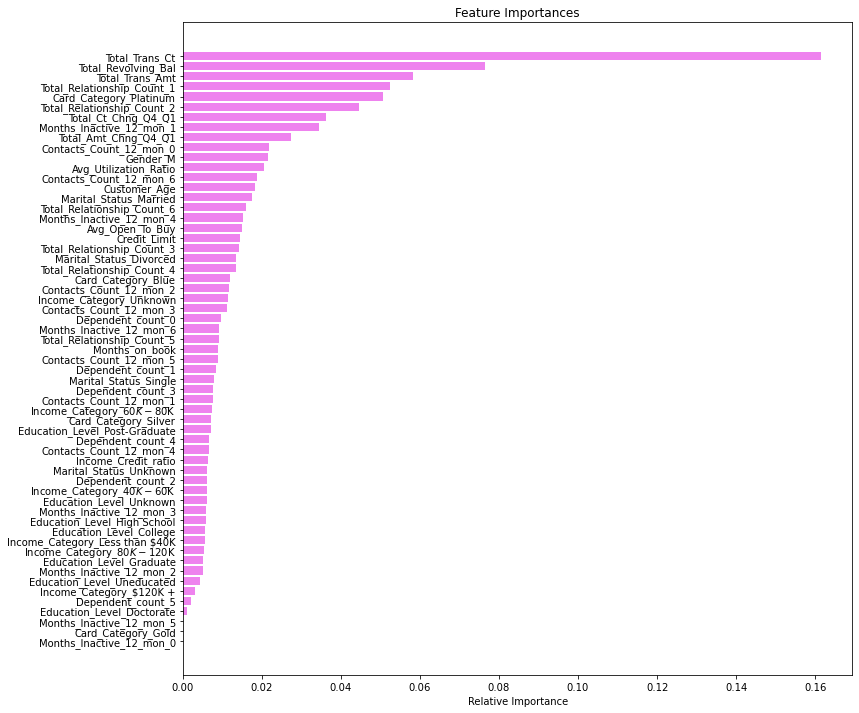

In [10]:
importances = estimator['xgb'].feature_importances_
indices = np.argsort(importances)
feature_names = list(estimator['dp'].feature_names)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Only 3 unimportant variables

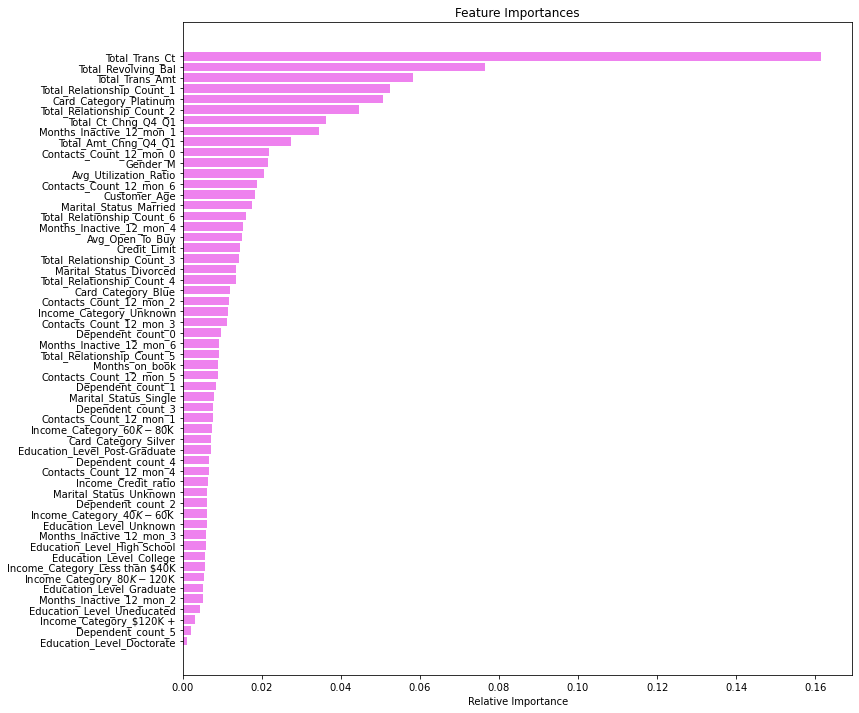

In [11]:
NON_important = importances == 0
feature_names_selected = np.delete(estimator['dp'].feature_names,NON_important)
importances_selected = np.delete(importances,NON_important)

importances = importances_selected
indices = np.argsort(importances_selected)
feature_names = list(feature_names_selected)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Hyperparameter tuning of XGBoost

In [12]:
# Prepare data reference for tuning client
object_ref_X_train = ray.put(X_train)
object_ref_y_train = ray.put(y_train)

2022-02-16 17:55:28,972	WARNING services.py:1856 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67059712 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.53gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


In [13]:
ll_scorer = metrics.make_scorer(metrics.log_loss, greater_is_better=False, needs_proba=True)

Hyperparameter tuning using ray-tune library and optimization algorithm HyperOptSearch.

In [19]:
def training_function(config):
    # Hyperparameters
    config['n_estimators'] = int(config['n_estimators'])      
    config['learning_rate'] = 10 ** config['learning_rate']
                                           
    X_train=ray.get(object_ref_X_train)
    y_train=ray.get(object_ref_y_train)
    
    sys.path.append( os.path.join(os.environ['PWD'],'scripts'))
    from Data_Prep import Data_Prep

    estimator = Pipeline([('dp', Data_Prep()),
                          ('ros', RandomOverSampler()), 
                          ("selector", ColumnTransformer([("selector", "passthrough", NON_important == False)], remainder="drop")),
                          ('xgb', XGBClassifier(random_state=1, eval_metric='logloss', use_label_encoder=False, **config))])
    
    cv_results = cross_validate(estimator, X_train, y_train, scoring=ll_scorer, cv=3, return_train_score=True)

    d = {'Logloss Training':np.mean(cv_results['train_score']), 'Logloss Test':np.mean(cv_results['test_score'])}
    
    tune.report(**d)

config = {
    "n_estimators": tune.randint(80, 120),
    "gamma": tune.uniform(0, 3),
    "subsample": tune.quniform(0.7, 0.95, 0.01),
    "colsample_bytree": tune.quniform(0.7, 0.95, 0.01),
    "colsample_bylevel": tune.quniform(0.7, 0.95, 0.01),    
    "learning_rate": tune.quniform(-2.0, -1.0, 0.2),  # powers of 10
}
analysis = tune.run(
    training_function,
    config=config, 
    metric='Logloss Test',
    mode="max",
    num_samples=48,
    search_alg=HyperOptSearch(random_state_seed=1),
    resume =  'AUTO',#"ERRORED_ONLY", 
    name='XGBoost_ros_selected_tuning', 
    local_dir=os.path.join(os.environ['PWD'],'data/ray_results'),
    verbose = 1)

2022-02-16 18:33:39,810	INFO tune.py:636 -- Total run time: 0.69 seconds (0.00 seconds for the tuning loop).


## Create and save the best model

In [20]:
config = analysis.best_config
config['learning_rate'] = 10 ** config['learning_rate']

# Fit the best algorithm to the data.
estimator = Pipeline([('dp', Data_Prep()), 
                      ('ros', RandomOverSampler()), 
                      ("selector", ColumnTransformer([("selector", "passthrough", NON_important == False)], remainder="drop")),
                      ('xgb', XGBClassifier(random_state=1, eval_metric='logloss', use_label_encoder=False, **config))])

estimator.fit(X_train, y_train)

Pipeline(steps=[('dp', Data_Prep()), ('ros', RandomOverSampler()),
                ('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.1, max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=118,
                               n_jobs=12, num_parallel_tree=1, predictor='auto',
                               random_state=1, reg_alpha=0, reg

In [21]:
model_path = os.path.join(os.environ['PWD'],'models/xgboost_ros_selected.pkl')
pickling_on = open(model_path,"wb")
pickle.dump(estimator, pickling_on)
pickling_on.close()
print('estimator pickled successfully!')

estimator pickled successfully!
